Import relevant Dipy's modules:

In [1]:
from dipy.sims.voxel import DKI_signal, multi_tensor_dki, single_tensor
import dipy.core.gradients as grad
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti

Import other external modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
matplotlib.style.use('fivethirtyeight')

# Simulations

"Monte Carlo simulations (50,000 trials) were performed to evaluate the performance of the different strategies in the estimation of fractional anisotropy (FA), mean diffusivity (MD) and mean kurtosis (MK)"

In [4]:
n_sims = 10000

"Throughout all experiments, FA and MD were estimated with the DTI model, whereas the MK was estimated with the DKI model."

# For the DTI model

"For the DTI model, the MD and FA were set to $0.8 × 10^{−3} mm^{2}/s$ and $0.85$, respectively. The b-value was $1000 s/mm^{2}$, and $60$ gradient directions – isotropically distributed over a unit sphere using Coulomb's law of repulsion (Jones et al., 1999) – were used. We included five non-DW signals."

Produce the 60 diffusion gradient directions:

In [5]:
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

Adding 5 non diffusion-weighted signals and the $60$ diffusion gradients for b-value = $1000 s.mm^{-2}$

In [6]:
bvecs = np.concatenate([np.zeros((5, 3)), hsph_updated.vertices])
bvals = np.concatenate([np.zeros((5)), np.ones(hsph_updated.vertices.shape[0]) * 1000.])

In [7]:
bvals.shape

(65L,)

In [8]:
gtab_dti = grad.gradient_table(bvals, bvecs)

Defining simulation parameters. The following l1, l2, l3 are adjusted to produce a MD of $0.8 × 10^{−3} mm^{2}/s$ and FA of $0.85$.

In [9]:
dti_model = dti.TensorModel(gtab_dti)

Noisy synthetic datawere obtained by adding zero-mean complex Gaussian noise to the noise-free DW signals, which were calculated from the ground truth tensors using Eq. (1). The absolute value of the resulting complex noisy signals was taken afterwards to obtain their magnitudes.

# For the DKI model

"For the DKI simulations, additional DW signals with b = 2500 s/mm2 were sampled along the same 60 directions. The MK was defined as 1.05, which is in agreement with values typically observed in the corpus
callosum of the healthy human brain (Lätt et al., 2012)."

In [10]:
bvecs = np.concatenate([np.zeros((5, 3)), hsph_updated.vertices, hsph_updated.vertices])
bvals = np.concatenate([np.zeros((5)), np.ones(hsph_updated.vertices.shape[0]) * 1000., np.ones(hsph_updated.vertices.shape[0]) * 2500.])

In [11]:
bvals.shape

(125L,)

In [12]:
gtab_dki = grad.gradient_table(bvals, bvecs)

In [13]:
dki_model = dki.DiffusionKurtosisModel(gtab_dki)

#Simulating diffusion tensor and kurtosis tensor 

According to the article diffusion tensor and kurtosis tensor are adjusted so that MD of $0.8 × 10^{−3} mm^{2}/s$, FA of $0.85$ and MK = $1.05$. 

In [14]:
l1i = ADi =  1.3 / 1000
l2i = l3i = RDi =  0.08 / 1000
l1e = ADe =  2.8 / 1000
l2e = l3e = RDe =  0.52 / 1000
fie = 60

In [15]:
mevals = np.array([[l1i, l2i, l3i],
                   [l1e, l2e, l3e]])

In [16]:
angles = [(90, 0), (90, 0)]
fractions = [fie, (100 - fie)]

Generate Ground truth signals for the DKI fit

In [17]:
sig_gt, dt, kt = multi_tensor_dki(gtab_dki, mevals, S0=1.0, angles=angles,
                                  fractions=fractions, snr=None)

In [18]:
dt

array([  1.90000000e-03,   0.00000000e+00,   2.56000000e-04,
         1.16341446e-19,   0.00000000e+00,   2.56000000e-04])

In [19]:
fit = dki_model.fit(sig_gt)

In [20]:
fit.model_params

array([  1.90000000e-03,   2.56000000e-04,   2.56000000e-04,
         1.00000000e+00,  -1.94942279e-14,   5.24932703e-15,
         1.95126714e-14,   8.66555799e-01,  -4.99080202e-01,
        -5.18034840e-15,  -4.99080202e-01,  -8.66555799e-01,
         2.50612609e+00,   2.15638227e-01,   2.15638227e-01,
         4.20172781e-13,   2.55887312e-13,  -3.42411538e-13,
         3.71423566e-13,   5.48546397e-13,  -3.33574336e-13,
         2.45043440e-01,   2.45043440e-01,   7.18794089e-02,
        -6.06549978e-14,  -1.15474831e-13,  -1.67382201e-13])

In [21]:
MK = fit.mk()

In [22]:
FA = fit.fa

In [23]:
MD = fit.md

Adding noise to the simulation ground truth (in future this simulates will only be used for the MK plot)

In [24]:
n_snr = 10
snr = 1/np.linspace(0.03, 0.1, n_snr)

In [25]:
sim_mk = np.empty((n_snr, n_sims))
sim_fa = np.empty((n_snr, n_sims))
sim_md = np.empty((n_snr, n_sims))

In [26]:
for snr_idx, this_snr in enumerate(snr):
    for sim_idx in range(n_sims):
        sig = DKI_signal(gtab_dki, dt, kt, S0=1.0, snr=this_snr)
        fit = dki_model.fit(sig)
        sim_mk[snr_idx, sim_idx] = fit.mk()
        sim_fa[snr_idx, sim_idx] = fit.fa
        sim_md[snr_idx, sim_idx] = fit.md 

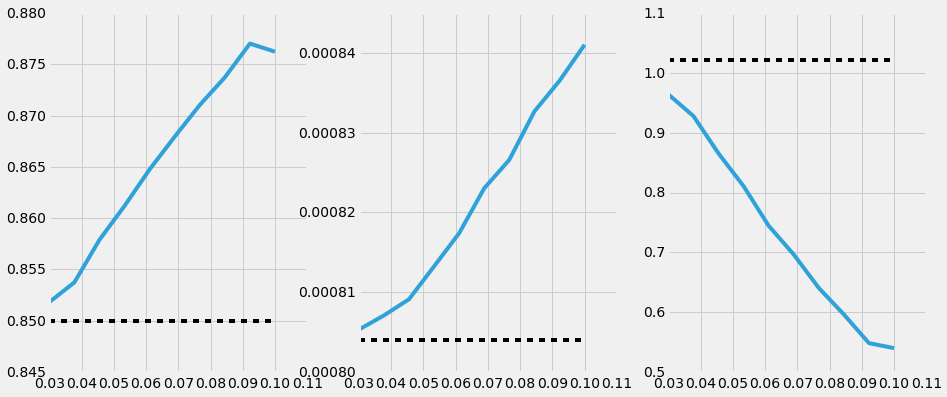

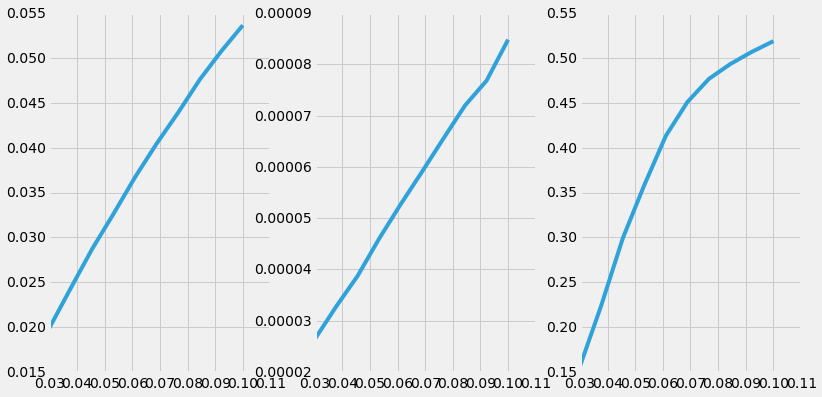

In [27]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.mean(sim_fa, -1))
ax[0].plot(1 / snr, np.ones(snr.shape) * FA, 'k--')
ax[1].plot(1 / snr, np.mean(sim_md, -1))
ax[1].plot(1 / snr, np.ones(snr.shape) * MD, 'k--')
ax[2].plot(1 / snr, np.mean(sim_mk, -1))
ax[2].plot(1 / snr, np.ones(snr.shape) * MK, 'k--')
fig.set_size_inches([14, 6])

fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.std(sim_fa, -1))
ax[1].plot(1 / snr, np.std(sim_md, -1))
ax[2].plot(1 / snr, np.std(sim_mk, -1))
fig.set_size_inches([12, 6])

Generate Ground truth signals for DTI fit

In [28]:
evals, evecs = dti.decompose_tensor(dti.from_lower_triangular(dt))

Adding noise to simulations

In [29]:
sim_fa = np.empty((n_snr, n_sims))
sim_md = np.empty((n_snr, n_sims))

In [30]:
for snr_idx, this_snr in enumerate(snr):
    for sim_idx in range(n_sims):
        sig = single_tensor(gtab_dti, S0=1, evals=evals, evecs=evecs, snr=this_snr)
        fit = dti_model.fit(sig)
        sim_fa[snr_idx, sim_idx] = fit.fa
        sim_md[snr_idx, sim_idx] = fit.md 

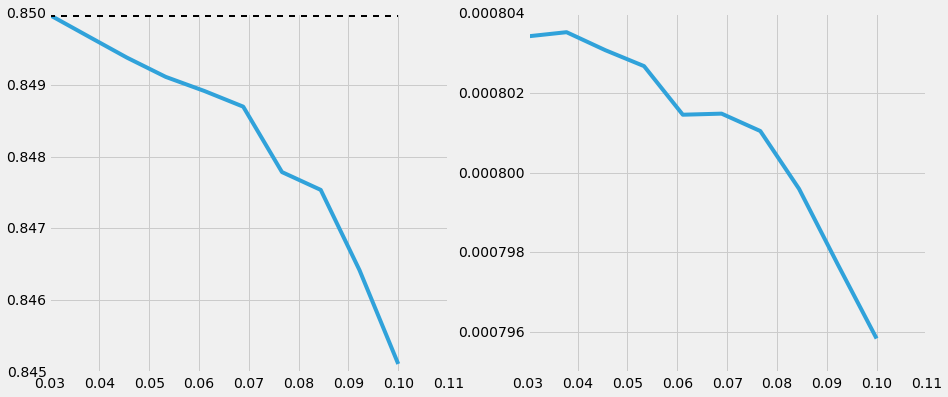

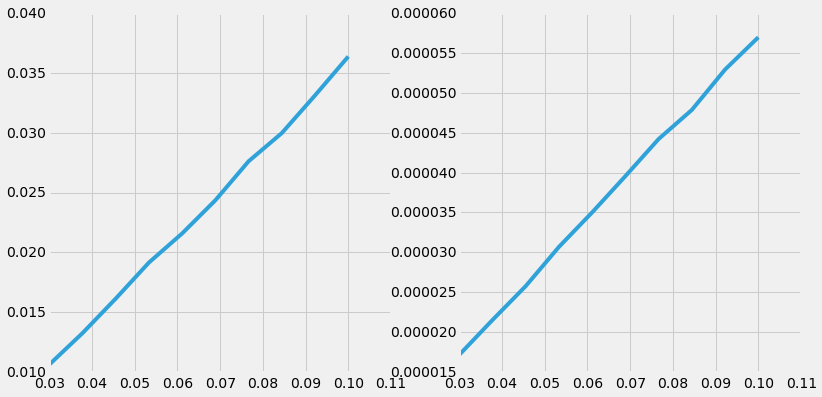

In [31]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(1 / snr, np.mean(sim_fa, -1))
ax[0].plot(1 / snr, np.ones(snr.shape) * FA, 'k--')
ax[1].plot(1 / snr, np.mean(sim_md, -1))
ax[1].plot(1 / snr, np.ones(snr.shape) * MD, 'k--')
fig.set_size_inches([14, 6])

fig, ax = plt.subplots(1, 2)
ax[0].plot(1 / snr, np.std(sim_fa, -1))
ax[1].plot(1 / snr, np.std(sim_md, -1))
fig.set_size_inches([12, 6])

#Testing simulation case where l2 and l3 are different

According to the article diffusion tensor and kurtosis tensor are adjusted so that MD of $0.8 × 10^{−3} mm^{2}/s$, FA of $0.85$ and MK = $1.05$. 

In [32]:
l1i =  1.3 / 1000
l2i = 0.1 /1000
l3i = 0.06 /1000
l1e =  2.8 / 1000
l2e = 0.58 /1000
l3e = 0.46 / 1000
fie = 60

In [33]:
mevals = np.array([[l1i, l2i, l3i],
                   [l1e, l2e, l3e]])

In [34]:
sig_gt, dt, kt = multi_tensor_dki(gtab_dki, mevals, S0=1.0, angles=angles,
                                  fractions=fractions, snr=None)

In [35]:
fit = dki_model.fit(sig_gt)

In [36]:
fit.model_params

array([  1.90000000e-03,   2.92000000e-04,   2.20000000e-04,
        -1.00000000e+00,  -1.92668390e-14,   2.92881809e-15,
        -1.92668390e-14,   1.00000000e+00,   3.37896378e-13,
         2.92881809e-15,  -3.37951889e-13,   1.00000000e+00,
         2.50612609e+00,   2.56627311e-01,   1.78213411e-01,
         4.09853754e-13,   2.67762383e-13,  -3.54859889e-13,
         3.91232413e-13,   5.58046454e-13,  -3.18182810e-13,
         2.67320116e-01,   2.22766763e-01,   7.12853642e-02,
        -4.70805628e-14,  -1.14287324e-13,  -1.71267192e-13])

In [37]:
MK = fit.mk()

In [38]:
FA = fit.fa

In [39]:
MD = fit.md

In [40]:
n_snr = 10
snr = 1/np.linspace(0.03, 0.1, n_snr)

In [41]:
sim_mk = np.empty((n_snr, n_sims))
sim_fa = np.empty((n_snr, n_sims))
sim_md = np.empty((n_snr, n_sims))

In [42]:
for snr_idx, this_snr in enumerate(snr):
    for sim_idx in range(n_sims):
        sig = DKI_signal(gtab_dki, dt, kt, S0=1.0, snr=this_snr)
        fit = dki_model.fit(sig)
        sim_mk[snr_idx, sim_idx] = fit.mk()
        sim_fa[snr_idx, sim_idx] = fit.fa
        sim_md[snr_idx, sim_idx] = fit.md 

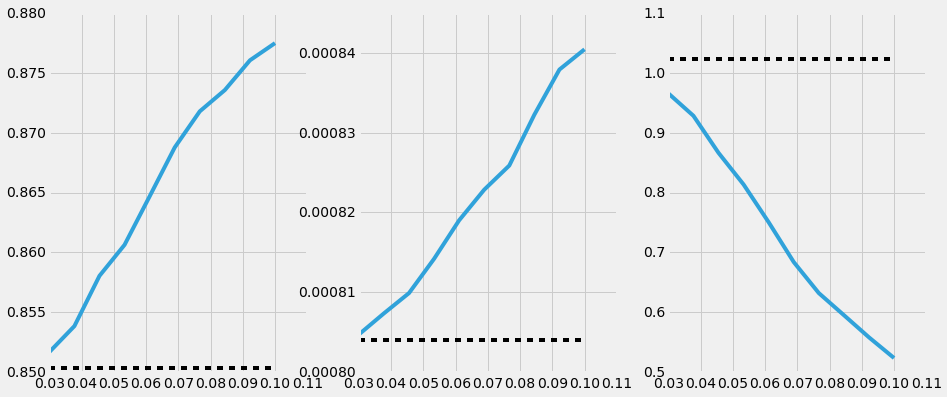

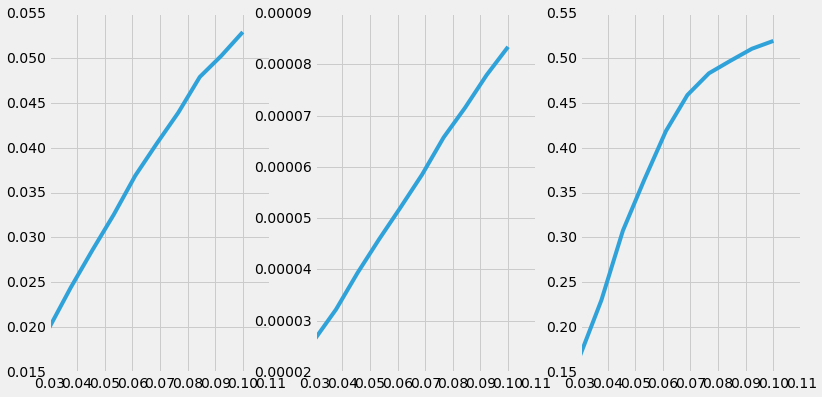

In [43]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.mean(sim_fa, -1))
ax[0].plot(1 / snr, np.ones(snr.shape) * FA, 'k--')
ax[1].plot(1 / snr, np.mean(sim_md, -1))
ax[1].plot(1 / snr, np.ones(snr.shape) * MD, 'k--')
ax[2].plot(1 / snr, np.mean(sim_mk, -1))
ax[2].plot(1 / snr, np.ones(snr.shape) * MK, 'k--')
fig.set_size_inches([14, 6])

fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.std(sim_fa, -1))
ax[1].plot(1 / snr, np.std(sim_md, -1))
ax[2].plot(1 / snr, np.std(sim_mk, -1))
fig.set_size_inches([12, 6])

# Testing Veraart tensors

In [44]:
kt_veraart = np.array([0.2632, 1.7217, 0.1677, 0.1068, -0.0070, 0.1243, 0.0102, 0.0191, -0.0869, 0.0032, 0, 0.3150, -0.0316, -0.0154, -0.0788])
dt_veraart = np.array([0.0005, 0.0000, 0.0029,  0.0000, -0.0003,  0.0005])
sig1 = DKI_signal(gtab_dki, dt=dt_veraart, kt=kt_veraart, S0=1.0, snr=None)

In [45]:
fit = dki_model.fit(sig1)

In [47]:
fit.model_params

array([  2.93693169e-03,   5.00000000e-04,   4.63068312e-04,
        -7.52516108e-14,   1.00000000e+00,  -3.23193883e-12,
        -9.92507557e-01,   3.20201042e-13,   1.22183264e-01,
         1.22183264e-01,   3.21691820e-12,   9.92507557e-01,
         2.63200000e-01,   1.72170000e+00,   1.67700000e-01,
         1.06800000e-01,  -7.00000000e-03,   1.24300000e-01,
         1.02000000e-02,   1.91000000e-02,  -8.69000000e-02,
         3.20000000e-03,  -2.16832916e-13,   3.15000000e-01,
        -3.16000000e-02,  -1.54000000e-02,  -7.88000000e-02])

In [48]:
MK = fit.mk()

In [49]:
FA = fit.fa

In [50]:
MD = fit.md

In [51]:
sim_mk = np.empty((n_snr, n_sims))
sim_fa = np.empty((n_snr, n_sims))
sim_md = np.empty((n_snr, n_sims))

In [52]:
for snr_idx, this_snr in enumerate(snr):
    for sim_idx in range(n_sims):
        sig = DKI_signal(gtab_dki, dt_veraart, kt_veraart, S0=1.0, snr=this_snr)
        fit = dki_model.fit(sig)
        sim_mk[snr_idx, sim_idx] = fit.mk()
        sim_fa[snr_idx, sim_idx] = fit.fa
        sim_md[snr_idx, sim_idx] = fit.md 

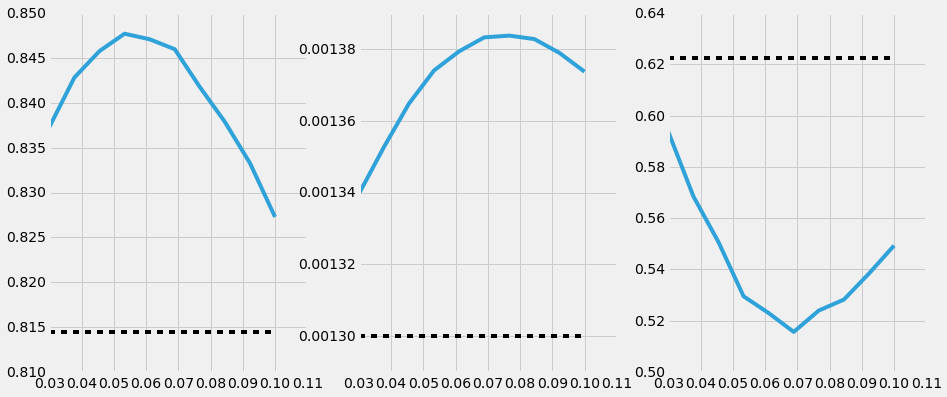

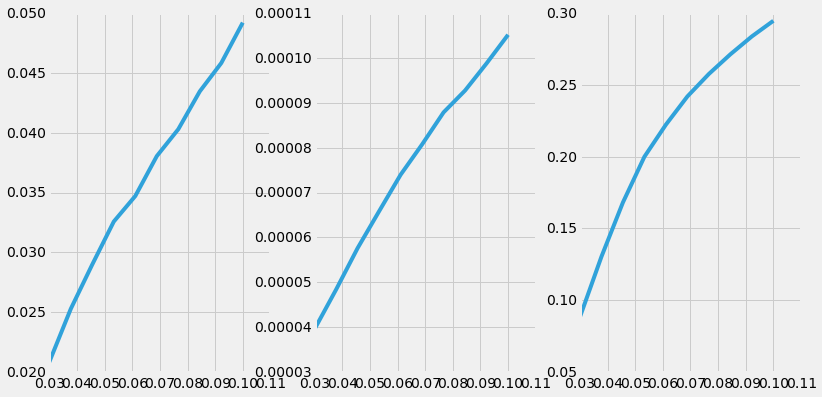

In [53]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.mean(sim_fa, -1))
ax[0].plot(1 / snr, np.ones(snr.shape) * FA, 'k--')
ax[1].plot(1 / snr, np.mean(sim_md, -1))
ax[1].plot(1 / snr, np.ones(snr.shape) * MD, 'k--')
ax[2].plot(1 / snr, np.mean(sim_mk, -1))
ax[2].plot(1 / snr, np.ones(snr.shape) * MK, 'k--')
fig.set_size_inches([14, 6])

fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.std(sim_fa, -1))
ax[1].plot(1 / snr, np.std(sim_md, -1))
ax[2].plot(1 / snr, np.std(sim_mk, -1))
fig.set_size_inches([12, 6])

In [55]:
MK

array(0.6223404597312433)

In [56]:
FA

0.81447304230023354

In [57]:
MD

0.0012999999999995912